# Analyse afvoerpiek Dwarsdiep 25 - 26 juli 2021  

Voor de herinrichting van het beekdal van het Dwarsdiep is in het voorjaar van 2021 een frequentieanalyse uitgevoerd van gemeten waterstanden benedenstrooms van gemaal Wemerpolder. Deze werd gebaseerd op metingen over de periode 1 mei 2012 17:15 tot en met 25 maart 2021 13:00.  
Kort na afronding van de rapportage viel een uitzonderlijke grote hoeveelheid neerslag die een afvoerpiek veroorzaakte op 25 en 26 juli 2021. Tijdens deze afvoerpiek steeg de waterstand tot -0,40 mNAP, ver boven de verwachting onder normale omstandigheden. In dit notebook wordt deze piek vergeleken met de waterstanden uit de eerder geanalyseerde periode.  

Auteur: Thomas de Meij (Staatsbosbeheer)  
Datum: 4 oktober 2021 

In [32]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker as tick
import seaborn as sns
import scipy
from scipy import stats
sns.set_style("whitegrid")
%matplotlib inline

datadir = r'..\02_data\validatie waterpeilen\\'
figdir = r'..\03_result\\waterstand juli 2021\\'

## Inlezen gegevens en validatie  

De gemeten waterstanden zijn aangeleverd op 24 september 2021 door Vincent de Looij van waterschap noorderzijlvest. Het is een Excelbestand met kwartierwaarden van de waterstand tussen 10 december 2020 15:00 uur en 24 september 2021 8:00 uur.

In [33]:
fpath = r'..\01_source\data wemerpolder september 2021\Wemerpolder_benedenstrooms.xlsx'
wmp21 = pd.read_excel(fpath,skiprows=4)
wmp21.columns = ['datumtijd','wmpnap']
wmp21

,datumtijd,wmpnap
0,2020-12-10 09:15:00,-0.93
1,2020-12-10 09:30:00,-0.94
2,2020-12-10 09:45:00,-0.93
3,2020-12-10 10:00:00,-0.93
4,2020-12-10 10:15:00,-0.93
...,...,...
35983,2021-09-24 07:00:00,-0.92
35984,2021-09-24 07:15:00,-0.92
35985,2021-09-24 07:30:00,-0.92
35986,2021-09-24 07:45:00,-0.92


De dataset bestaat uit 35988 kwartierwaarden tussen 10 december 2020 9:15 tot en met 24 september 2021 8:00. Onderstaande controle op duplicaten in de kolom datumtijd laat zien dat er geen datums dubbel voorkomen:

In [34]:
# aantal dubbele waarden voor datumtijd:
doubledates = wmp21.duplicated(subset=['datumtijd'],keep=False)
print(f'Aantal dubbele waarden voor datumtijd in wemerpolder: {len(wmp21[doubledates])}')

Aantal dubbele waarden voor datumtijd in wemerpolder: 0


Vervolgens wordt de meetreeks uitgelijnd op een index van kwartierwaarden tussen het begin en het eind van de aangeleverde meetreeks. Hierdoor is zeker dat alle kwartierwaarden voorkomen in de index. Eventuele ontbrekende kwartierwaarden krijgen een missing value voor de waterstand:

In [35]:
# create index of 15 minute values
starttime = wmp21.iloc[0,0]
endtime = wmp21.iloc[-1,0]
dtindex = pd.to_datetime(pd.date_range(start=starttime, end=endtime, freq='15min'))

# set datumtijd as index and realign to new index
wmp21 = wmp21.set_index(keys='datumtijd',drop=True).reindex(dtindex)

In [36]:
# count missing values in orignal series of quarter hours
print(f'Aantal ontbrekende kwartierwaarden in Wemerpolder {wmp21.isna().sum()}')

Aantal ontbrekende kwartierwaarden in Wemerpolder wmpnap    8
dtype: int64


Het aantal ontbrekende kwartierwaarden is 8, een verwaarloosbaar klein aantal, zodat verder niet is onderzocht welke waarnemingen ontbreken. Beschrijvende statistieken van de kwartierwaarden zien er als volgt uit:

In [37]:
wmp21.describe()

,wmpnap
count,27636.000000
mean,-0.864813
std,0.062507
min,-1.020000
25%,-0.900000
50%,-0.870000
75%,-0.840000
max,-0.400000


In [38]:
# opslaan dataset
fpath = f'{datadir}kwartierwaarden wemerpolder 2021.csv' 
wmp21.to_csv(fpath)

## Omrekening naar dagwaarden  

Voor de frequentieanalyse zijn kwartierwaarden omgerekend naar dagwaarden. Een dagwaarde is daarbij berekend als het 85e percentiel van alle kwartierwaarden op een dag. Deze omrekening wordt ook toegepast op de nieuwe reeks. Daarna worden beide reeksen samengevoegd tot een reeks van dagwaarden over de periode 1 mei 2012 tot en met 23 september.

### Reeks van dagwaarden 2021

In [39]:
daystats = wmp21['wmpnap'].groupby(pd.Grouper(freq='D')).agg(['mean', 'median', 'min', 'max'])
daystats['range'] = daystats['max']-daystats['min']

def q85(x):
    return x.quantile(0.85)
daystats['q85'] = wmp21['wmpnap'].groupby(pd.Grouper(freq='D')).agg([q85])

daystats.head(5)

,mean,median,min,max,range,q85
2020-12-10,-0.925424,-0.93,-0.94,-0.90,0.04,-0.91
2020-12-11,-0.908854,-0.91,-0.93,-0.87,0.06,-0.89
2020-12-12,-0.898542,-0.90,-0.93,-0.86,0.07,-0.88
2020-12-13,-0.879896,-0.88,-0.93,-0.83,0.10,-0.85
2020-12-14,-0.937917,-0.94,-0.96,-0.90,0.06,-0.92


In [40]:
# pandas series from dataframe with daily values
wmp21_q85 = daystats['q85']['2021-03-26':].squeeze() #axis='columns')

### Samenvoegen reeks 2012 - 2021 met reeks 2021  

In [41]:
# read daily values 2012 - 2021
fpath = f'{datadir}wemerpolder_dagwaarden_q85.csv'
wmp_q85 = pd.read_csv(fpath,index_col='datumtijd',parse_dates=['datumtijd']).squeeze(axis='columns')
wmp_q85

datumtijd
2012-05-01   -0.82
2012-05-02   -0.80
2012-05-03   -0.82
2012-05-04   -0.82
2012-05-05   -0.80
              ... 
2021-03-21   -0.81
2021-03-22   -0.83
2021-03-23   -0.84
2021-03-24   -0.83
2021-03-25   -0.82
Name: wmpnap, Length: 3251, dtype: float64

De meetreeks van dagwaarden in 2021 wordt toegevoegd aan de reeks van dagwaarden die eerder is geanalyseerd:

In [42]:
wmp_q85 = pd.concat([wmp_q85,wmp21_q85])
wmp_q85

2012-05-01   -0.82
2012-05-02   -0.80
2012-05-03   -0.82
2012-05-04   -0.82
2012-05-05   -0.80
              ... 
2021-09-20   -0.92
2021-09-21   -0.90
2021-09-22   -0.91
2021-09-23   -0.93
2021-09-24   -0.92
Length: 3434, dtype: float64

In [43]:
# save new series 2012 - september 2021
fpath = f'{datadir}dagwaarden wemerpolder 2012 - september 2021.csv' 
wmp_q85.to_csv(fpath)

## Grafieken van waterstanden  

Om de reeks te beoordelen worden enkele plaatjes gemaakt: 
- de meetreeks van 2021 als kwartierwaarden en dagwaarden
- de kwartierwaarden van de piek in juli 2021
- de dagwaarden in de zomer voor alle seizoenen.

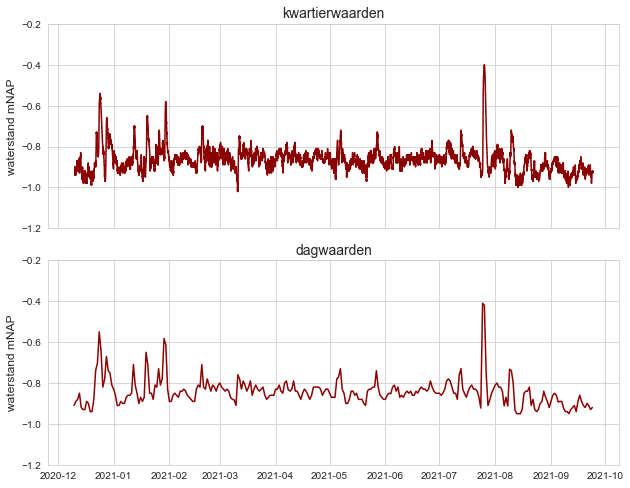

In [44]:
def plot_rawdata(quarters,days):
    """Plot timegraph of raw measurements"""
    fig,axs = plt.subplots(nrows=2, ncols=1,sharex=True,sharey=True)
    fig.set_size_inches(9,7) # w,h

    x = quarters.index.values
    y = quarters.values
    axs[0].plot(x,y,color='#8b0000')
    axs[0].set_title('kwartierwaarden',fontsize=14.)
    
    x = days.index.values
    y = days.values
    axs[1].plot(x,y,color='#8b0000')
    axs[1].set_title(label='dagwaarden',fontsize=14.)
       
    for ax in axs:
        ax.set_ylabel('waterstand mNAP',fontsize=12.)
    
    fig.tight_layout(pad=1.5)
    axs[0].set_ylim(-1.2,-0.2)

    return fig,axs

fig,ax = plot_rawdata(wmp21,daystats['q85'])
fpath = f'{figdir}tijdreeksen kwartierwaarden Wemerpolde 2021.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')
plt.show()

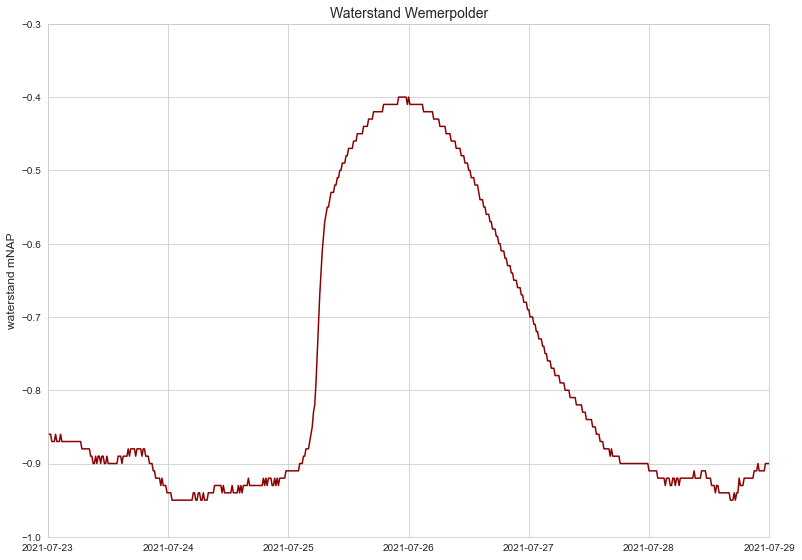

In [48]:
def plot_piek(quarters):
    """Plot timegraph of raw measurements"""
    fig,axs = plt.subplots(nrows=1, ncols=1,sharex=True,sharey=True)
    fig.set_size_inches(11,8) # w,h

    x = quarters.index.values
    y = quarters.values
    axs.plot(x,y,color='#8b0000')
    axs.set_title('Waterstand Wemerpolder',fontsize=14.)
    8
    #for ax in axs:
    axs.set_ylabel('waterstand mNAP',fontsize=12.)
    
    fig.tight_layout(pad=1.5)
    axs.set_ylim(-1.0,-0.3)
    axs.set_xlim(quarters.index[0],quarters.index[-1])

    return fig,axs


piek2021 = wmp21['2021-07-23 00:00:00':'2021-07-29 00:00:00']
fig,ax = plot_piek(piek2021)
fpath = f'{figdir}tijdreeksen kwartierwaarden Wemerpolde juli 2021.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')
plt.show()

### Grafiek verloop waterstand zomer in verschillende jaren

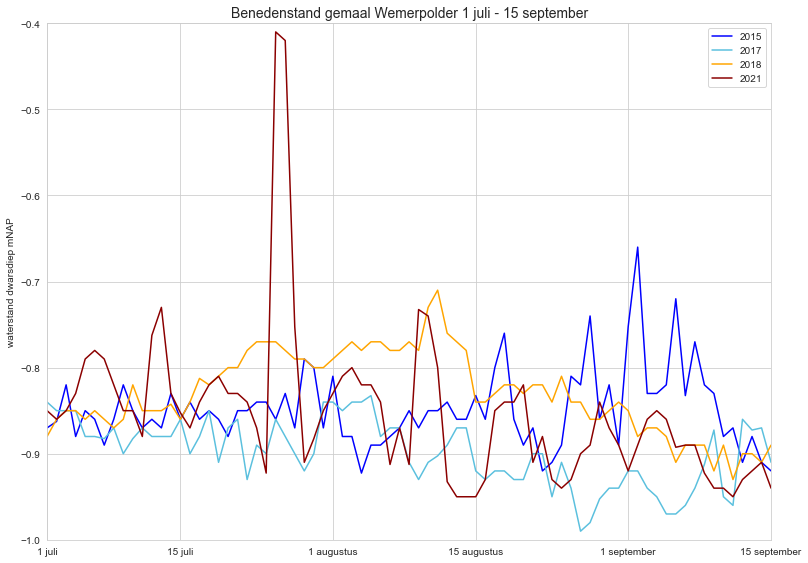

In [46]:
def plot_season(waterlevels,years,colors):
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(11,8) # w,h
    fig.tight_layout(pad=2.0)

    for i,year in enumerate(years):
        #waterlevels = wmp[f'{year}-07-01':f'{year}-09-15'].values
        ax.plot(waterlevels[i],color=colors[i],label=f'{year}')

        ax.set_xticks([0,14,30,45,61,76])
        ax.set_xticklabels(['1 juli','15 juli','1 augustus','15 augustus','1 september','15 september'])
        ax.set_title('Benedenstand gemaal Wemerpolder 1 juli - 15 september',fontsize=14)
        ax.set_xlim(0,76)
        ax.set_ylim(-1.00,-0.40)
        ax.grid(b=True, which='both', axis='both',)
        ax.set_ylabel('waterstand dwarsdiep mNAP')
        ax.legend(loc="upper right")

    return fig


years = [2015,2017,2018,2021]
colors = ['#0000ff','#5bc0de','#ffa500','#8b0000']

waterlevels = []
for i,year in enumerate(years):
    waterlevels.append(wmp_q85[f'{year}-07-01':f'{year}-09-15'].values)

fig = plot_season(waterlevels,years,colors)             
fpath = f'{figdir}wemerpolder - waterstanden zomer 2021.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')